In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.contrib.layers.python.layers import layers

from collections import Counter
from sklearn.manifold import TSNE
from utils import make_dir, read_or_create

## Read data

In [2]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    return [make_codones(seq[i:]) for i in range(3)]

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
        
    return codones

In [3]:
seq_df = pd.read_table("data/family_classification_sequences.tab")
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
all_codones = read_or_create(read_path="data/all_codones.pickle",
                             producer=lambda: create_all_codones(seq_df))

Saving data/all_codones.pickle


## Process data

In [5]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model """
    
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
 
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
                
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target

def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays """
    
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch

def flatten(x):
    return [item for sublist in x for item in sublist]

def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    counter = Counter(flatten(all_codones))
    ordered = map(lambda it: it[0], counter.most_common())
    dictionary = {cod: i for i, cod in enumerate(ordered)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = (cod_to_dict(cod, dictionary) for cod in all_codones)
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    return get_batch(single_gen, batch_size=batch_size)

In [6]:
dictionary = make_dictionary(all_codones)

In [7]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

## SkipGramModel

In [87]:
from lazy import lazy

class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")
        self.saver = tf.train.Saver()

    @lazy
    def placeholders(self):
        with tf.name_scope("data"):
            center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name="center_words")
            target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name="target_words")
            return center_words, target_words
    
    @lazy
    def embedding(self):
        with tf.name_scope("embed"):
            initial = tf.Variable(tf.random_uniform([self.vocab_size, self.embed_size], -1.0, 1.0))
            
            weights_init = tf.truncated_normal_initializer(mean=0, stddev=0.05)
            biases_init = tf.constant_initializer(value=0.3)
             
            layer_1 = layers.fully_connected(inputs=initial,
                                             num_outputs=self.embed_size,
                                             weights_initializer=weights_init,
                                             biases_initializer=biases_init)
            
            dropout = tf.nn.dropout(layer_1, keep_prob=0.5)
            
            layer_2 = layers.fully_connected(inputs=dropout,
                                             num_outputs=self.embed_size,
                                             weights_initializer=weights_init,
                                             biases_initializer=biases_init)
            
            return layer_2
    
    @lazy
    def loss(self):
        center_words, target_words = self.placeholders
            
        with tf.name_scope("loss"):
            embed = tf.nn.embedding_lookup(self.embedding, center_words, name="embed")
            
            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name="nce_weight")
            nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name="nce_bias")

            # define loss function to be NCE loss function
            return tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                 biases=nce_bias,
                                                 labels=target_words,
                                                 inputs=embed,
                                                 num_sampled=self.num_sampled,
                                                 num_classes=self.vocab_size), name="loss")
    
    @lazy
    def optimizer(self):
        return tf.train.AdagradOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)

    @lazy
    def summary(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            return tf.summary.merge_all()
        
    def build(self):
        self.optimizer
        self.summary

## Train model

In [88]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100 # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = 0.8
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

graph = tf.Graph()
with graph.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [100]:
from utils import make_dir

def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir("checkpoints")
 
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname("checkpoints/checkpoint"))

        # if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter("improved_graph/lr" + str(learning_rate), sess.graph)
        
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            
            center_words, target_words = model.placeholders
            feed_dict = {center_words: centers, target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary],
                                              feed_dict=feed_dict)
            
            writer.add_summary(summary, global_step=index)
            
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print("Average loss at step {:>5}: {:5.1f}".format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, "checkpoints/skip-gram", index)

        final_embed_matrix = sess.run(model.embedding)
        return final_embed_matrix

In [90]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step  1999:  19.5
Average loss at step  3999:  15.3
Average loss at step  5999:  13.0
Average loss at step  7999:  11.0
Average loss at step  9999:   9.4
Average loss at step 11999:   7.4
Average loss at step 13999:   6.5
Average loss at step 15999:   6.1
Average loss at step 17999:   5.0
Average loss at step 19999:   4.8
Average loss at step 21999:   3.9
Average loss at step 23999:   4.2
Average loss at step 25999:   3.6
Average loss at step 27999:   3.4
Average loss at step 29999:   2.8
Average loss at step 31999:   2.7
Average loss at step 33999:   2.3
Average loss at step 35999:   3.0
Average loss at step 37999:   2.8
Average loss at step 39999:   2.3
Average loss at step 41999:   2.4
Average loss at step 43999:   2.8
Average loss at step 45999:   2.3
Average loss at step 47999:   2.5
Average loss at step 49999:   2.6
Average loss at step 51999:   2.3
Average loss at step 53999:   2.2
Average loss at step 55999:   2.2
Average loss at step 57999:   2.1
Average loss a

## Results

### Embedding

In [91]:
tsne = TSNE(n_components=2, random_state=42)
X_embeded = tsne.fit_transform(final_embed_matrix)

In [92]:
tsne_df = pd.DataFrame(X_embeded, columns=["x0", "x1"])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df["codone"] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,5.387017,-4.703344,AAA
1,3.175273,-0.241745,LLL
2,9.176517,-9.023504,ALA
3,1.385716,-10.245254,LAA
4,11.133995,-2.248333,AAL


In [93]:
filename = "data/acid_properties.csv"
props = pd.read_csv(filename)

In [94]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres["acid"] = some_c
    return dres

In [95]:
save_path = "data/all_acid_dicts.pickle"
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

Reading data/all_acid_dicts.pickle


In [96]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,AAA,1.800000,71.077900,13.0,88.600000
1,LLL,3.800000,113.157600,22.0,166.700000
2,ALA,2.466667,85.104467,16.0,114.633333
3,LAA,2.466667,85.104467,16.0,114.633333
4,AAL,2.466667,85.104467,16.0,114.633333


In [97]:
final_df = all_acid_df.join(tsne_df.set_index("codone"), on="acid")
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,AAA,1.800000,71.077900,13.0,88.600000,5.387017,-4.703344
1,LLL,3.800000,113.157600,22.0,166.700000,3.175273,-0.241745
2,ALA,2.466667,85.104467,16.0,114.633333,9.176517,-9.023504
3,LAA,2.466667,85.104467,16.0,114.633333,1.385716,-10.245254
4,AAL,2.466667,85.104467,16.0,114.633333,11.133995,-2.248333


### Visualization

In [98]:
def plot_embedding_properties(final_df):
    """ Plot properties of our acids """
    
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(["hydrophobicity", "mass", "number_of_atoms", "volume"]):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

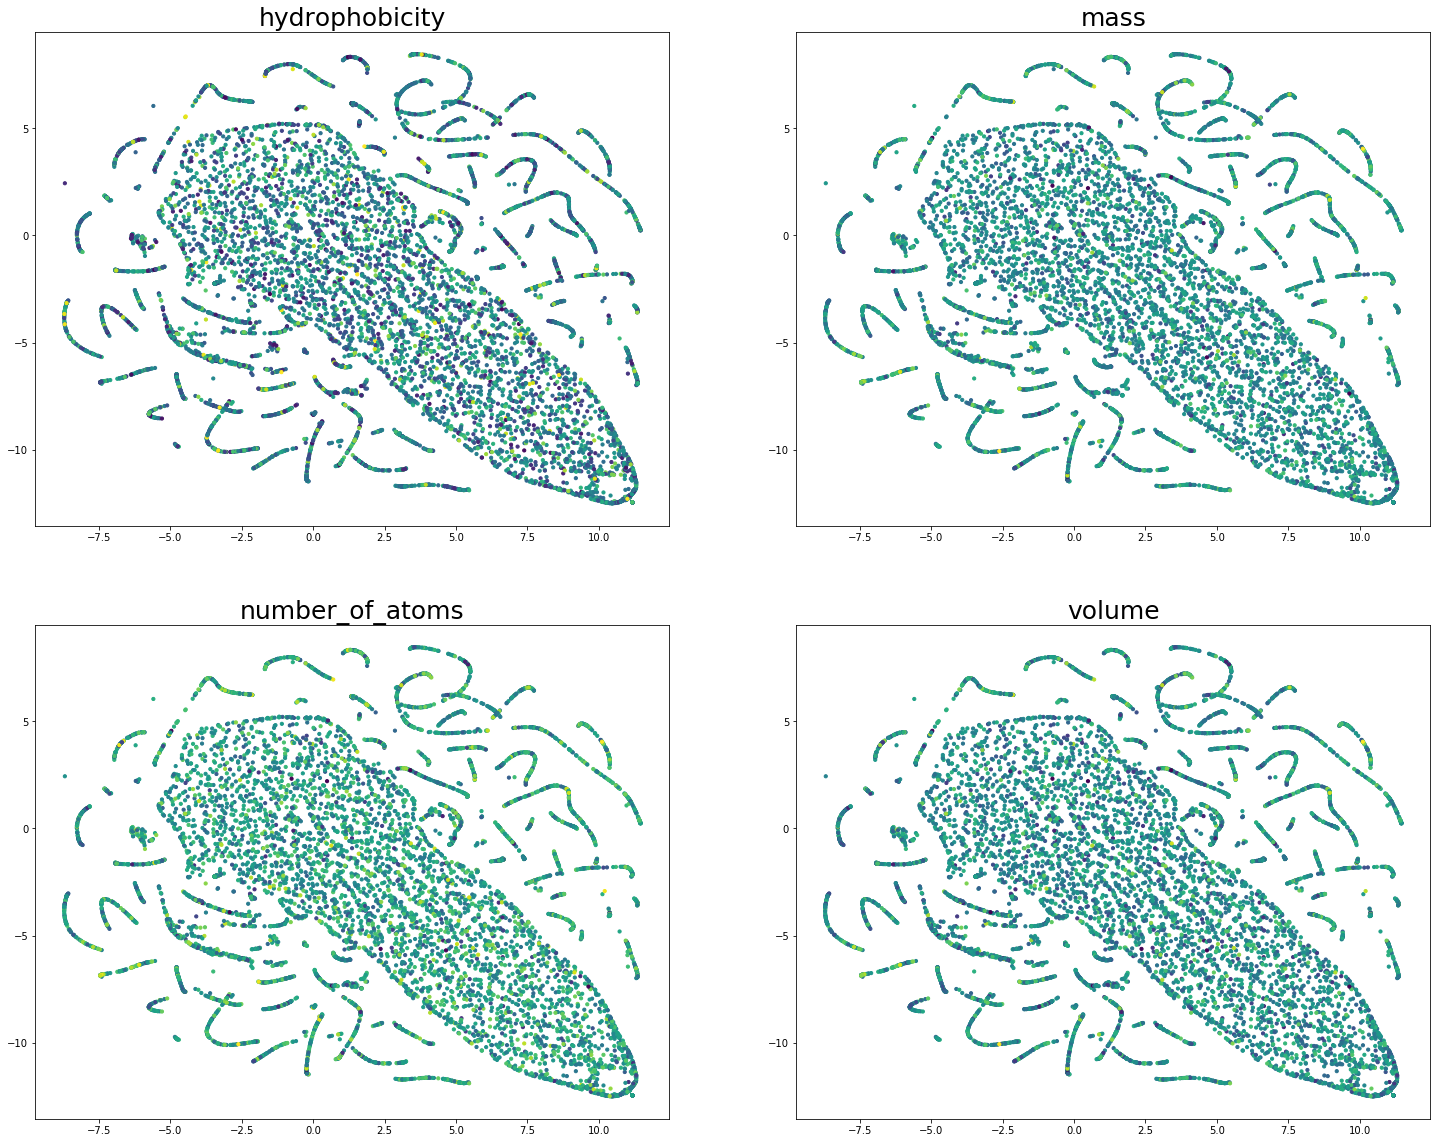

In [99]:
plot_embedding_properties(final_df)